# Biweekly Report 7

# Jake Watts

# Object Detection Architecture

In this notebook, I implement a simple object localization and classification architecture on the MNIST dataset. Since in the MNIST dataset the hand-written digits are all more or less centered in the picture, the images are augmented by placing the digits in a random position on a 75x75 pixel image. I initially use a simple architecture to create bounding boxes and classifications. Then I attempt to improve the performance of the model by widening and lengthening the model and evaluating the changes in performance.

In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, Add
from tensorflow.keras.layers import SeparableConv2D, ReLU, ELU
from tensorflow.keras.layers import BatchNormalization, MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.utils import plot_model
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.7.0


Functions for drawing bounding boxes on images which will be used for visualization.

In [ ]:
im_width = 75
im_height = 75
use_normalized_coordinates = True

def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color=[],
                                       thickness=1,
                                       display_str_list=()):
  """Draws bounding boxes on image (numpy array).
  Args:
    image: a numpy array object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list_list: a list of strings for each bounding box.
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  image_pil = PIL.Image.fromarray(image)
  rgbimg = PIL.Image.new("RGBA", image_pil.size)
  rgbimg.paste(image_pil)
  draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness,
                               display_str_list)
  return np.array(rgbimg)
  

def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color=[],
                                 thickness=1,
                                 display_str_list=()):
  """Draws bounding boxes on image.
  Args:
    image: a PIL.Image object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: a list of strings for each bounding box.
                           
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                               boxes[i, 2], color[i], thickness, display_str_list[i])
        
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=1,
                               display_str=None,
                               use_normalized_coordinates=True):
  """Adds a bounding box to an image.
  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.
  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: string to display in box
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  draw = PIL.ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
  


Functions for transforming data and displaying data.

In [ ]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      validation_bboxes = validation_bboxes.numpy()
      break
    for training_digits, (training_labels, training_bboxes) in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      training_bboxes = training_bboxes.numpy()
      break
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels, training_bboxes,
          validation_digits, validation_labels, validation_bboxes)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (75*n, 75), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*75,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75*n]), n, axis=1), axis=0), [n, 75*75])
  return font_digits, font_labels


# utility to display a row of digits with their predictions
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_labels = labels[indexes]

  n_iou = []
  if len(iou) > 0:
    n_iou = iou[indexes]

  if (len(pred_bboxes) > 0):
    n_pred_bboxes = pred_bboxes[indexes,:]

  if (len(bboxes) > 0):
    n_bboxes = bboxes[indexes,:]


  n_digits = n_digits * 255.0
  n_digits = n_digits.reshape(n, 75, 75)
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])
  
  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    bboxes_to_plot = []
    if (len(pred_bboxes) > i):
      bboxes_to_plot.append(n_pred_bboxes[i])
    
    if (len(bboxes) > i):
      bboxes_to_plot.append(n_bboxes[i])

    img_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i], boxes=np.asarray(bboxes_to_plot), color=['red', 'green'], display_str_list=["true", "pred"])
    plt.xlabel(n_predictions[i])
    plt.xticks([])
    plt.yticks([])
    
    if n_predictions[i] != n_labels[i]:
      ax.xaxis.label.set_color('red')

    
    
    plt.imshow(img_to_draw)

    if len(iou) > i :
      color = "black"
      if (n_iou[i][0] < iou_threshold):
        color = "red"
      ax.text(0.2, -0.3, "iou: %s" %(n_iou[i][0]), color=color, transform=ax.transAxes)


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In this report, I used the TPU as my hardware accelerator rather than the GPU which I normally used. Although it appears it led to faster training times, I also had more errors where my notebook would disconnect from the TPU initially, not sure why.

In [ ]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.123.25.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.123.25.74:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.123.25.74:8470']
Number of accelerators:  8


Setting batch size based on number of accelerators.

In [ ]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync # Gobal batch size.


Functions to read in training and testing data and randomly place digits on the image.

In [ ]:

'''
Transforms each image in dataset by pasting it on a 75x75 canvas at random locations.
'''
def read_image_tfds(image, label):
    xmin = tf.random.uniform((), 0 , 48, dtype=tf.int32)
    ymin = tf.random.uniform((), 0 , 48, dtype=tf.int32)
    image = tf.reshape(image, (28,28,1,))
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
    image = tf.cast(image, tf.float32)/255.0
    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)
   
    xmax = (xmin + 28) / 75
    ymax = (ymin + 28) / 75
    xmin = xmin / 75
    ymin = ymin / 75
    return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])
  
'''
Loads and maps the training split of the dataset using the map function. Note that we try to load the gcs version since TPU can only work with datasets on Google Cloud Storage.
'''
def get_training_dataset():
      
      with  strategy.scope():
        dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
        dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
        dataset = dataset.repeat() # Mandatory for Keras for now
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
        dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
      return dataset

'''
Loads and maps the validation split of the dataset using the map function. Note that we try to load the gcs version since TPU can only work with datasets on Google Cloud Storage.
'''  
def get_validation_dataset():
    dataset = tfds.load("mnist", split="test", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

    #dataset = dataset.cache() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
with strategy.scope():
  training_dataset = get_training_dataset()
  validation_dataset = get_validation_dataset()

Here we can visualize the transformed MNIST data. The numbers appear in random positons within the square are otherwise unchanged from the orginial dataset.

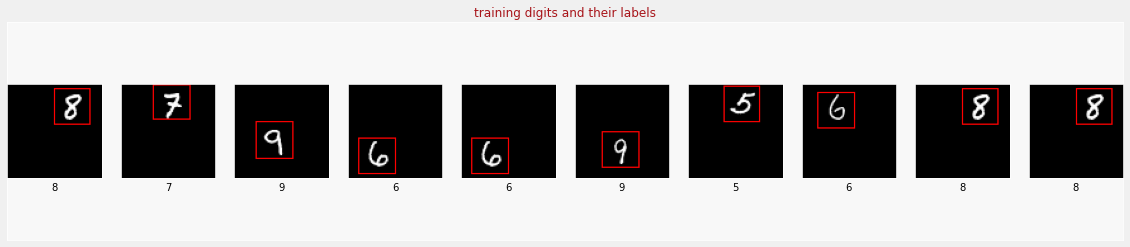

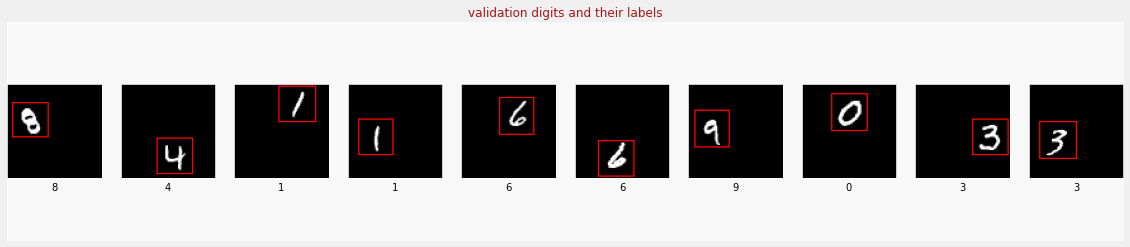

In [ ]:
(training_digits, training_labels, training_bboxes,
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset, validation_dataset, 10)

display_digits_with_boxes(training_digits, training_labels, training_labels, np.array([]), training_bboxes, np.array([]), "training digits and their labels")
display_digits_with_boxes(validation_digits, validation_labels, validation_labels, np.array([]), validation_bboxes, np.array([]), "validation digits and their labels")


Here we define a simple network architecture. The code for this architecure comes fom the following tutorial: https://colab.research.google.com/drive/12YB0Nmy0lFhZzw_ZBdb4gkBmbAc0qGce

The feature extractor contains three convolutional layers with 16, 32 and 64 filters respectively, with average pooling following the convolutional layers. The dense layers flatten the output and then are fed into a dense layer. The dense layer outputs goes to both a classification layer and a bounding box regression layer. The model in total has 426,638 trainable parameters.

In [ ]:
'''
Feature extractor is the CNN that is made up of convolution and pooling layers.
'''
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, activation='relu', kernel_size=3, input_shape=(75, 75, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    return x

'''
dense_layers adds a flatten and dense layer.
This will follow the feature extraction layers
'''
def dense_layers(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  return x


'''
Classifier defines the classification output.
This has a set of fully connected layers and a softmax layer.
'''
def classifier(inputs):

  classification_output = tf.keras.layers.Dense(10, activation='softmax', name = 'classification')(inputs)
  return classification_output


'''
This function defines the regression output for bounding box prediction. 
Note that we have four outputs corresponding to (xmin, ymin, xmax, ymax)
'''
def bounding_box_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(units = '4', name = 'bounding_box')(inputs)
    return bounding_box_regression_output


def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)

    '''
    The model branches here.  
    The dense layer's output gets fed into two branches:
    classification_output and bounding_box_output
    '''
    classification_output = classifier(dense_output)
    bounding_box_output = bounding_box_regression(dense_output)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_output, bounding_box_output])

    return model
  

def define_and_compile_model(inputs):
  model = final_model(inputs)
  
  model.compile(optimizer='adam', 
              loss = {'classification' : 'categorical_crossentropy',
                      'bounding_box' : 'mse'
                     },
              metrics = {'classification' : 'accuracy',
                         'bounding_box' : 'mse'
                        })
  return model

    
with strategy.scope():
  inputs = tf.keras.layers.Input(shape=(75, 75, 1,))
  model = define_and_compile_model(inputs)

# print model layers
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 73, 73, 16)   160         ['input_1[0][0]']                
                                                                                                  
 average_pooling2d (AveragePool  (None, 36, 36, 16)  0           ['conv2d[0][0]']                 
 ing2D)                                                                                           
                                                                                                  
 conv2d_1 (Conv2D)              (None, 34, 34, 32)   4640        ['average_pooling2d[0][0]']  

Below is a plot of the model architecture which gives both a bounding box regression and a classification for the images provided.

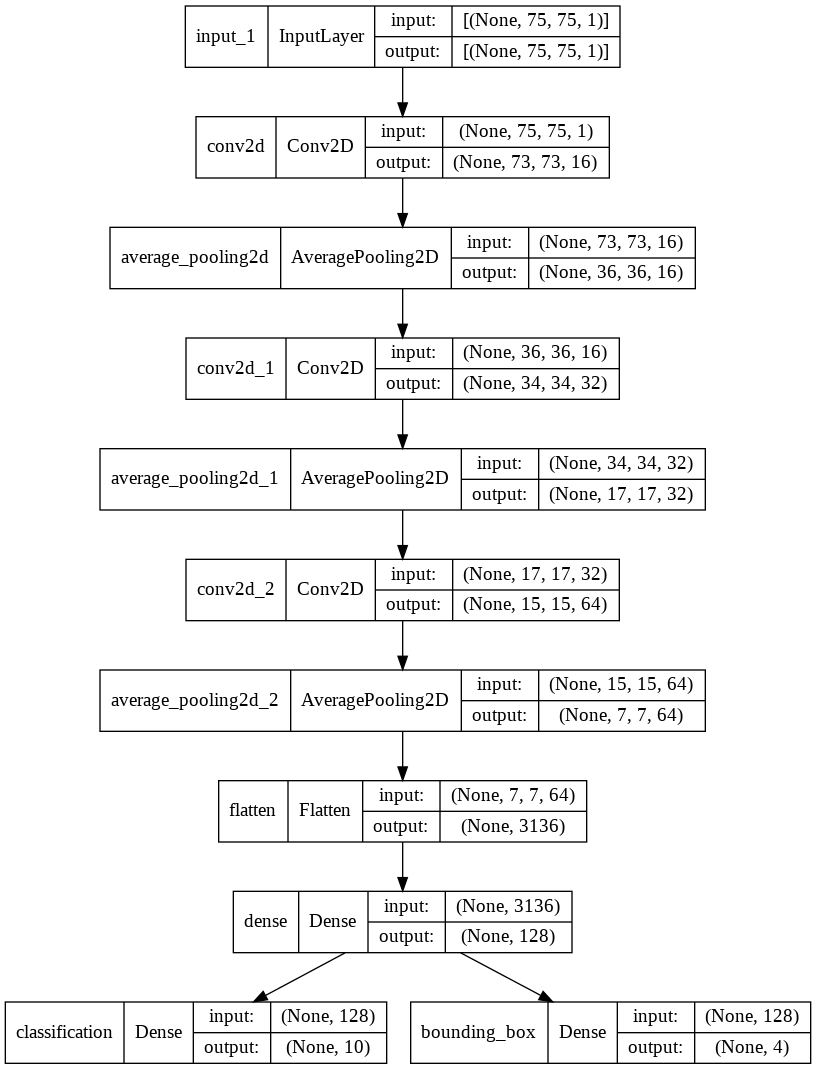

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Now we can train the model. 

In [ ]:
EPOCHS = 10 
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
validation_steps = 1

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

loss, classification_loss, bounding_box_loss, classification_accuracy, bounding_box_mse = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", classification_accuracy)

Epoch 1/10
117/117 [==============================] - 10s 43ms/step - loss: 2.0832 - classification_loss: 2.0622 - bounding_box_loss: 0.0209 - classification_accuracy: 0.2346 - bounding_box_mse: 0.0209 - val_loss: 1.4319 - val_classification_loss: 1.4213 - val_bounding_box_loss: 0.0106 - val_classification_accuracy: 0.5065 - val_bounding_box_mse: 0.0106
Epoch 2/10
117/117 [==============================] - 4s 30ms/step - loss: 0.9649 - classification_loss: 0.9516 - bounding_box_loss: 0.0133 - classification_accuracy: 0.6921 - bounding_box_mse: 0.0133 - val_loss: 0.5703 - val_classification_loss: 0.5457 - val_bounding_box_loss: 0.0245 - val_classification_accuracy: 0.8386 - val_bounding_box_mse: 0.0245
Epoch 3/10
117/117 [==============================] - 4s 30ms/step - loss: 0.4559 - classification_loss: 0.4423 - bounding_box_loss: 0.0136 - classification_accuracy: 0.8680 - bounding_box_mse: 0.0136 - val_loss: 0.3441 - val_classification_loss: 0.3347 - val_bounding_box_loss: 0.0094 - v

After 10 epcohs of training, the validation accuracy is 95.4% for classification. The loss is shown below which decreases rapidly for two epochs and then more slowly afterwards. The bounding box loss decreases a little during training but does not see as big of changes as the classification loss.

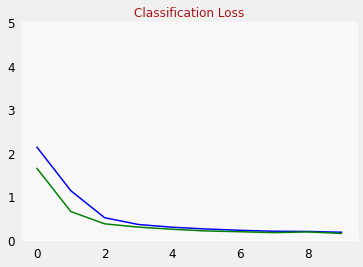

In [ ]:
plot_metrics("classification_loss", "Classification Loss")

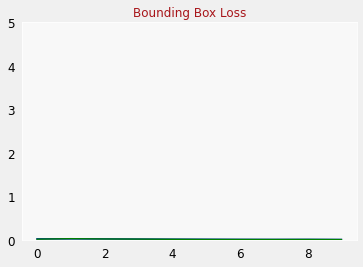

In [ ]:
plot_metrics("bounding_box_loss", "Bounding Box Loss")

Below is the function to calculate the intersection-over-union which is to evaluate the accuracy of the bounding box compared to the ground-truth.

In [ ]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area
    
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

Below I visualize the bounding box predictions in red and the ground truth predictions in green and calculate the number of precitions in the testing set which have an IOU of 0.6 or greater. 

It appears that the images visualized with an IOU below 0.6 do contain the number but are too big of boxes, meaning they are not specific enough predictions. Overall 55.82% percent of the bounding boxes are above the threshold while the remainder are below.

Number of predictions where iou > threshold(0.6): 5582
Number of predictions where iou < threshold(0.6): 4418


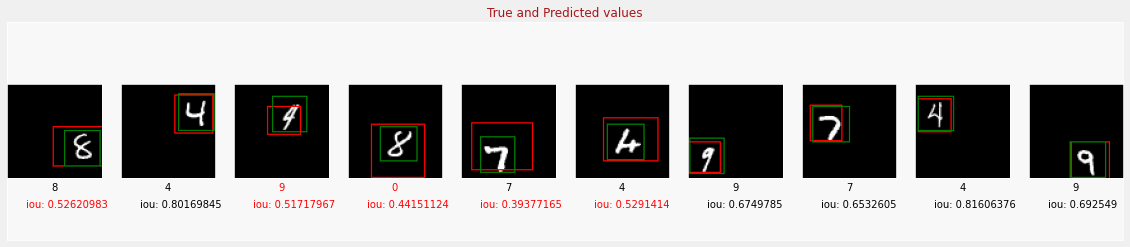

In [ ]:
# recognize validation digits
predictions = model.predict(validation_digits, batch_size=64)
predicted_labels = np.argmax(predictions[0], axis=1)

predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, validation_bboxes)

iou_threshold = 0.6

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))


display_digits_with_boxes(validation_digits, predicted_labels, validation_labels, predicted_bboxes, validation_bboxes, iou, "True and Predicted values")

The function below creates a convolutional layers with batch normalization.

In [ ]:
def conv_bn(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

In order to improve the performance of the bounding boxes, I will first try increasing the numbers of filters per layer making the feature extractor wider. The total number of parameters is now 5,918,222 which is approximately 12 times more than the initial architecture.

In [ ]:
'''
Feature extractor is the CNN that is made up of convolution and pooling layers.
'''
def feature_extractor(inputs):
    x = conv_bn(inputs, filters =32, kernel_size =3, strides=2)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    
    x = conv_bn(inputs, filters =128, kernel_size =3, strides=2)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    return x

'''
dense_layers adds a flatten and dense layer.
This will follow the feature extraction layers
'''
def dense_layers(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  return x


'''
Classifier defines the classification output.
This has a set of fully connected layers and a softmax layer.
'''
def classifier(inputs):

  classification_output = tf.keras.layers.Dense(10, activation='softmax', name = 'classification')(inputs)
  return classification_output


'''
This function defines the regression output for bounding box prediction. 
Note that we have four outputs corresponding to (xmin, ymin, xmax, ymax)
'''
def bounding_box_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(units = '4', name = 'bounding_box')(inputs)
    return bounding_box_regression_output


def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)

    '''
    The model branches here.  
    The dense layer's output gets fed into two branches:
    classification_output and bounding_box_output
    '''
    classification_output = classifier(dense_output)
    bounding_box_output = bounding_box_regression(dense_output)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_output, bounding_box_output])

    return model
  

def define_and_compile_model(inputs):
  model = final_model(inputs)
  
  model.compile(optimizer='adam', 
              loss = {'classification' : 'categorical_crossentropy',
                      'bounding_box' : 'mse'
                     },
              metrics = {'classification' : 'accuracy',
                         'bounding_box' : 'mse'
                        })
  return model

    
with strategy.scope():
  inputs = tf.keras.layers.Input(shape=(75, 75, 1,))
  model = define_and_compile_model(inputs)

# print model layers
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 38, 38, 128)  1152        ['input_6[0][0]']                
                                                                                                  
 batch_normalization_16 (BatchN  (None, 38, 38, 128)  512        ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 average_pooling2d_16 (AverageP  (None, 19, 19, 128)  0          ['batch_normalization_16[0]

I also increased the number of epochs as 10 was a fairly small amount.

In [ ]:
EPOCHS = 30
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
validation_steps = 1

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

loss, classification_loss, bounding_box_loss, classification_accuracy, bounding_box_mse = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", classification_accuracy)

Epoch 1/30
117/117 [==============================] - 10s 40ms/step - loss: 2.5606 - classification_loss: 2.1629 - bounding_box_loss: 0.3977 - classification_accuracy: 0.2177 - bounding_box_mse: 0.3977 - val_loss: 2.4147 - val_classification_loss: 2.2539 - val_bounding_box_loss: 0.1608 - val_classification_accuracy: 0.1340 - val_bounding_box_mse: 0.1608
Epoch 2/30
117/117 [==============================] - 4s 31ms/step - loss: 1.8572 - classification_loss: 1.7711 - bounding_box_loss: 0.0861 - classification_accuracy: 0.3778 - bounding_box_mse: 0.0861 - val_loss: 2.2963 - val_classification_loss: 2.1218 - val_bounding_box_loss: 0.1745 - val_classification_accuracy: 0.3717 - val_bounding_box_mse: 0.1745
Epoch 3/30
117/117 [==============================] - 4s 32ms/step - loss: 1.4583 - classification_loss: 1.3473 - bounding_box_loss: 0.1110 - classification_accuracy: 0.5426 - bounding_box_mse: 0.1110 - val_loss: 2.0799 - val_classification_loss: 1.8736 - val_bounding_box_loss: 0.2063 - v

The validation accuracy after training has decreased to 86.6%. It also appeared that this model learned the classifications more slowly than the first model which would make sense due to an incrased number of parameters.

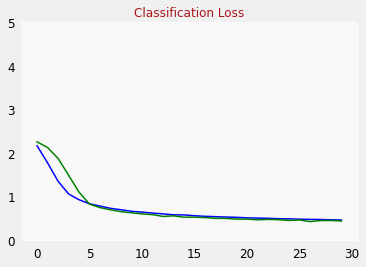

In [ ]:
plot_metrics("classification_loss", "Classification Loss")

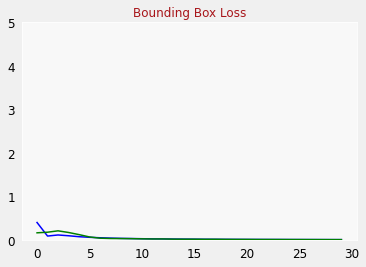

In [ ]:
plot_metrics("bounding_box_loss", "Bounding Box Loss")

Although the classification accuracy is worse with this model the bounding boxes have improved with 60.33% of the predicted boxes are above the threshold. The incorrect boxes also appear to be closer in size to the correct boxes, unlike the previous model.

Number of predictions where iou > threshold(0.6): 6033
Number of predictions where iou < threshold(0.6): 3967


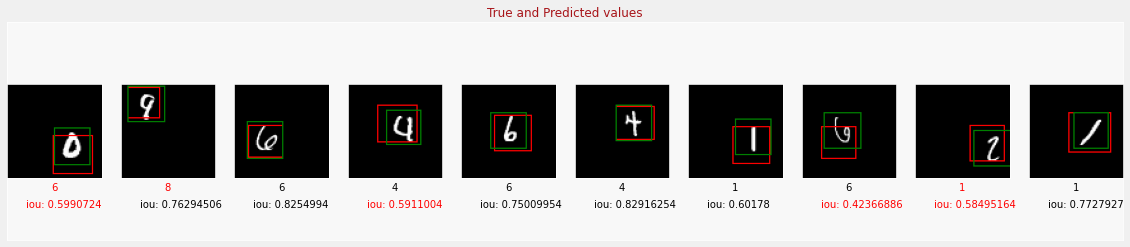

In [ ]:
# recognize validation digits
predictions = model.predict(validation_digits, batch_size=64)
predicted_labels = np.argmax(predictions[0], axis=1)

predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, validation_bboxes)

iou_threshold = 0.6

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))


display_digits_with_boxes(validation_digits, predicted_labels, validation_labels, predicted_bboxes, validation_bboxes, iou, "True and Predicted values")

Finally I wanted to try creating a longer rather than wider model and seeing how that effects model performance. This contains an extra convolutional layer and none of the layers are as wide as the widest in the original model. In terms of trainable parameters this model falls in between the previous two models with 1,480,942 trainable parameters.

In [ ]:
def feature_extractor(inputs):
    x = conv_bn(inputs, filters =16, kernel_size =3, strides=2)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = conv_bn(x, filters =32, kernel_size =3, strides=1)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    
    x = conv_bn(inputs, filters =16, kernel_size =3, strides=2)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = conv_bn(inputs, filters =32, kernel_size =3, strides=2)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    return x

def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)

    '''
    The model branches here.  
    The dense layer's output gets fed into two branches:
    classification_output and bounding_box_output
    '''
    classification_output = classifier(dense_output)
    bounding_box_output = bounding_box_regression(dense_output)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_output, bounding_box_output])

    return model
  

def define_and_compile_model(inputs):
  model = final_model(inputs)
  
  model.compile(optimizer='adam', 
              loss = {'classification' : 'categorical_crossentropy',
                      'bounding_box' : 'mse'
                     },
              metrics = {'classification' : 'accuracy',
                         'bounding_box' : 'mse'
                        })
  return model

    
with strategy.scope():
  inputs = tf.keras.layers.Input(shape=(75, 75, 1,))
  model = define_and_compile_model(inputs)

# print model layers
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 38, 38, 32)   288         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_10 (BatchN  (None, 38, 38, 32)  128         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 average_pooling2d_10 (AverageP  (None, 19, 19, 32)  0           ['batch_normalization_10[0]

The model is set to train for 30 epochs as well.

In [ ]:
EPOCHS = 30
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
validation_steps = 1

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

loss, classification_loss, bounding_box_loss, classification_accuracy, bounding_box_mse = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", classification_accuracy)

Epoch 1/30
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


117/117 [==============================] - 8s 37ms/step - loss: 2.1524 - classification_loss: 2.0484 - bounding_box_loss: 0.1040 - classification_accuracy: 0.2716 - bounding_box_mse: 0.1040 - val_loss: 2.4991 - val_classification_loss: 2.2297 - val_bounding_box_loss: 0.2693 - val_classification_accuracy: 0.2500 - val_bounding_box_mse: 0.2693
Epoch 2/30
117/117 [==============================] - 3s 28ms/step - loss: 1.5568 - classification_loss: 1.4816 - bounding_box_loss: 0.0752 - classification_accuracy: 0.4956 - bounding_box_mse: 0.0752 - val_loss: 2.3397 - val_classification_loss: 2.0651 - val_bounding_box_loss: 0.2746 - val_classification_accuracy: 0.3050 - val_bounding_box_mse: 0.2746
Epoch 3/30
117/117 [==============================] - 3s 28ms/step - loss: 1.1205 - classification_loss: 1.0630 - bounding_box_loss: 0.0575 - classification_accuracy: 0.6488 - bounding_box_mse: 0.0575 - val_loss: 1.8723 - val_classification_loss: 1.6527 - val_bounding_box_loss: 0.2196 - val_classific

The classification accuracy is 87.51% which is still not an improvement from the original model although it is slightly beter than the second model. It is similar to the second model in that the training progress is slower as well.

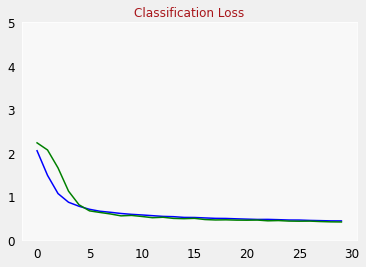

In [ ]:
plot_metrics("classification_loss", "Classification Loss")

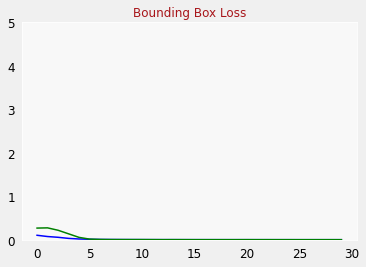

In [ ]:
plot_metrics("bounding_box_loss", "Bounding Box Loss")

This model has the best performance for bounding boxes with 71.36% of the bounding boxes being above the threshold.

Number of predictions where iou > threshold(0.6): 7136
Number of predictions where iou < threshold(0.6): 2864


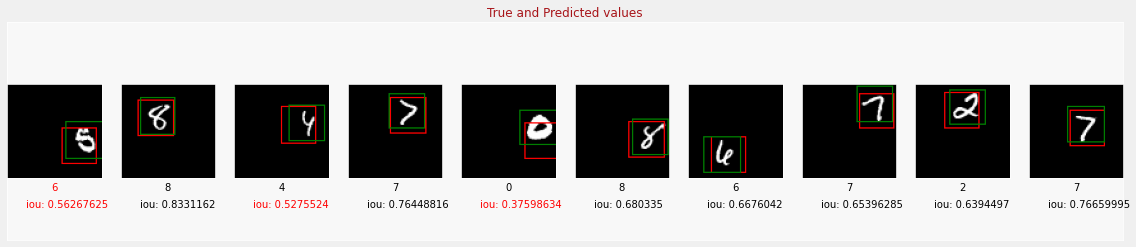

In [ ]:
# recognize validation digits
predictions = model.predict(validation_digits, batch_size=64)
predicted_labels = np.argmax(predictions[0], axis=1)

predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, validation_bboxes)

iou_threshold = 0.6

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))


display_digits_with_boxes(validation_digits, predicted_labels, validation_labels, predicted_bboxes, validation_bboxes, iou, "True and Predicted values")

# Summary

In conclusion, modifying the network archtitecture has, in both cases, improved the bounding boxes from the original model, although the change in architecture did not improve the classification accuracy. Increasing the width or depth had the expected effect of improving bounding box performance however the decrease in classification accuracy surprised me. 

The table below summarizes the results. Model 1 is the best model is classification is the most important while model 3 is the best for bounding box accuracy.

Model|Classification Accuracy|IOU Above Threshold
-----|-----|-----
Model 1|95.4%|55.82%
Model 2|86.6%|60.33%
Model 3|87.5%|71.36%

Although using pretrained networks with popularized architectures would result in better performance experimenting with the architecture and training gave me a better understanding of how the classification architeture works. In the next notebook however I will use a preteained model.